<a href="https://colab.research.google.com/github/CheeseGue/DataScience/blob/main/Processor/processor_Horses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

processor.ipynb

# **馬の健康への影響を予測する**
[Predict Health Outcomes of Horses](https://www.kaggle.com/competitions/playground-series-s3e22/overview)

# 参考資料
**書籍**


**Kaggle**
- [[PG S3 E22]📊EDA + Modeling📈](https://www.kaggle.com/code/yaaangzhou/pg-s3-e22-eda-modeling)


**自分で作成したファイル**
- Home_Credit_Default_Risk
- 肝硬変の転帰の多クラス予測

**その他**


## ライブラリ・データセットのインポート

In [5]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [6]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from lightgbm import LGBMClassifier # 特徴量の重要度評価で用いる

## 実行時間を調べるために使う

In [7]:
import datetime
import time
import math

start_time = time.time()

def changeHMS(s):
    h = math.floor(s / 3600)
    if h > 0:
        s = s - h * 3600
        indi_h = str(h) + 'h'
    else:
        indi_h = ''
    m = math.floor(s / 60)
    if m > 0:
        indi_m = str(m) + 'm'
    else:
        indi_m = ''
    s = math.floor(s % 60)
    time = indi_h + indi_m + str(s) + 's'
    return time

In [8]:
FILE_PATH = ''
OUTPUT_DIR = ''

train = pd.read_csv(FILE_PATH + 'train.csv')
test = pd.read_csv(FILE_PATH + 'test.csv')

train_id = train['id']

test_id = test['id']

target = train['outcome']
target_col = 'outcome'

target_name = str(train.iloc[:, [18]].columns.tolist()) # カラム数-2の値が目的変数

df = pd.concat([train, test], axis=0)
df.reset_index(inplace=True)

# 説明変数をデータ型ごとに代入する
numerical_features = df._get_numeric_data().columns
categorical_features = df.drop(numerical_features, axis=1).columns

In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head(10)

,index,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.5,decreased,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.0,absent,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,3.5,None,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.0,decreased,distend_small,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,7.0,normal,normal,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived
5,5,5,no,adult,529642,38.1,56.0,32.0,normal,normal,bright_pink,less_3_sec,depressed,hypomotile,none,none,more_1_liter,5.0,decreased,firm,49.0,8.0,cloudy,2.8,no,0,0,0,yes,lived
6,6,6,yes,adult,534787,38.3,36.0,16.0,cool,reduced,normal_pink,less_3_sec,severe_pain,normal,slight,none,more_1_liter,2.0,decreased,None,43.0,75.0,cloudy,1.0,no,3111,0,0,yes,euthanized
7,7,7,no,adult,529461,39.2,114.0,24.0,cool,reduced,pale_cyanotic,more_3_sec,mild_pain,hypomotile,moderate,slight,none,4.5,absent,distend_small,57.0,7.6,serosanguious,4.5,yes,2207,0,0,yes,died
8,8,8,no,adult,528742,37.4,48.0,12.0,cool,reduced,normal_pink,less_3_sec,alert,hypermotile,slight,slight,more_1_liter,7.0,normal,firm,40.0,7.8,cloudy,2.6,no,0,0,0,yes,lived
9,9,9,yes,adult,529640,38.3,129.0,48.0,cool,reduced,pale_pink,less_3_sec,depressed,absent,moderate,slight,none,4.4,None,None,57.0,4.9,cloudy,2.9,yes,3209,0,0,yes,died


## 前処理

### 欠損値の補完

In [10]:
def missing_values(df):

    return df

### 外れ値の修正

In [11]:
def outlier(df):
    df['lesion_2'] = df['lesion_2'].apply(lambda x: 1 if x>0 else 0)

    return df

### スケーリング（標準化）

- MinMaxScaler(正規化)

In [12]:
def scaling(df):
    df_scale = df[numerical_features]
    sc = MinMaxScaler()
    df[numerical_features] = pd.DataFrame(sc.fit_transform(df_scale), columns = df_scale.columns)

    return df

## 特徴量エンジニアリング

### 特徴量の作成

In [13]:
def create_new_features(df):
    df["pain"] = df["pain"].replace('slight', 'moderate')
    df["peristalsis"] = df["peristalsis"].replace('distend_small', 'normal')
    df["rectal_exam_feces"] = df["rectal_exam_feces"].replace('serosanguious', 'absent')
    df["nasogastric_reflux"] = df["nasogastric_reflux"].replace('slight', 'none')

    df["abs_rectal_temp"] = (df["rectal_temp"] - 37.8).abs()

    return df

### カテゴリ変数のエンコーディング

* One-HotEncoding

In [14]:
def one_hot_encoding(df, cat_cols):
    df = pd.get_dummies(df, columns=cat_cols)
    df[target_col] = df[target_col].map({'died':0,'euthanized':1,'lived':2})

    return df

- LabelEncoding

In [15]:
def label_encoder(df):
    categorical_columns = df.select_dtypes(include=['object']).columns

    for column in categorical_columns:
        df[column] = df[column].fillna('').astype('str') # 欠損値の補完をする
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])

    return df

### 特徴量の選択

#### 特徴量の重要度評価

In [16]:
def feature_importance_evaluation(df):
    # 訓練データをX(説明変数)とy（目的変数）に分割する
    X = df.select_dtypes(include=['float', 'int'])
    X = X.drop(['outcome'], axis=1) # 目的変数を指定する
    y = target # 目的変数を指定する

    for column in X.columns.tolist():
        X[column] = X[column].apply(lambda x: np.log(x + 1))

    # 特徴量の重要度評価
    lgb = LGBMClassifier(
        random_state=42,
    )

    lgb.fit(X, y)
    importance = lgb.feature_importances_

    feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
        .sort_values(ascending=True, by='importance')

    return feature_importance

#### 特徴量の削除

In [17]:
def drop_columns(df):
    drop_list = [
        'lesion_3', 'rectal_temp',
    ]
    dropped_df = df.drop(columns=drop_list)

    return dropped_df

### データセットの更新

In [18]:
# 前処理
df = missing_values(df)
df = outlier(df)
# df = scaling(df) # 標準化したい時のみ実行する

# 特徴量エンジニアリング
df = create_new_features(df)
df = drop_columns(df)

ohe_cols = ["mucous_membrane"] # One-Hot Encodingしたい水準数の少ないカラムを指定する
df = one_hot_encoding(df, ohe_cols)
df = label_encoder(df)

In [19]:
train = df[df.loc[:, 'id'] < 1235]
test = df[df.loc[:, 'id'] >= 1235]

train_x = train.drop(columns=['outcome', 'id'])
train_y = target
test_x = test.drop(columns=['outcome', 'id'])

X = train_x.values
y = train_y.values
# y = y.astype(int)

df.head()

,index,id,surgery,age,hospital_number,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,cp_data,outcome,abs_rectal_temp,mucous_membrane_None,mucous_membrane_bright_pink,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink
0,0,0,1,0,530001,132.0,24.0,2,4,3,2,1,4,3,1,6.5,2,2,57.0,8.5,3,3.4,1,2209,0,0,0.0,0.3,0,0,0,1,0,0,0
1,1,1,1,0,533836,88.0,12.0,2,3,3,4,1,1,1,2,2.0,1,2,33.0,64.0,3,2.0,1,2208,0,0,1.0,0.3,0,0,0,0,0,1,0
2,2,2,1,0,529812,120.0,28.0,2,4,2,3,3,1,3,3,3.5,0,1,37.0,6.4,3,3.4,1,5124,0,0,2.0,0.5,0,0,0,0,0,0,1
3,3,3,1,0,5262541,72.0,30.0,1,4,3,4,3,1,3,2,2.0,2,2,53.0,7.0,2,3.9,1,2208,0,1,2.0,0.7,0,0,0,0,0,0,1
4,4,4,0,0,5299629,52.0,48.0,3,3,2,1,3,2,3,1,7.0,4,4,47.0,7.3,2,2.6,0,0,0,1,2.0,0.2,0,0,0,0,1,0,0


In [20]:
# 特徴量の重要度評価
train_importance = train.drop(['id'], axis=1)
feature_importance = feature_importance_evaluation(train_importance)
feature_importance

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 882
[LightGBM] [Info] Number of data points in the train set: 1235, number of used features: 25
[LightGBM] [Info] Start training from score -1.102669
[LightGBM] [Info] Start training from score -1.593373
[LightGBM] [Info] Start training from score -0.766197


,importance
lesion_2,0
age,44
capillary_refill_time,79
surgical_lesion,82
peripheral_pulse,98
cp_data,105
surgery,111
peristalsis,125
temp_of_extremities,134
abdomen,146


<Axes: >

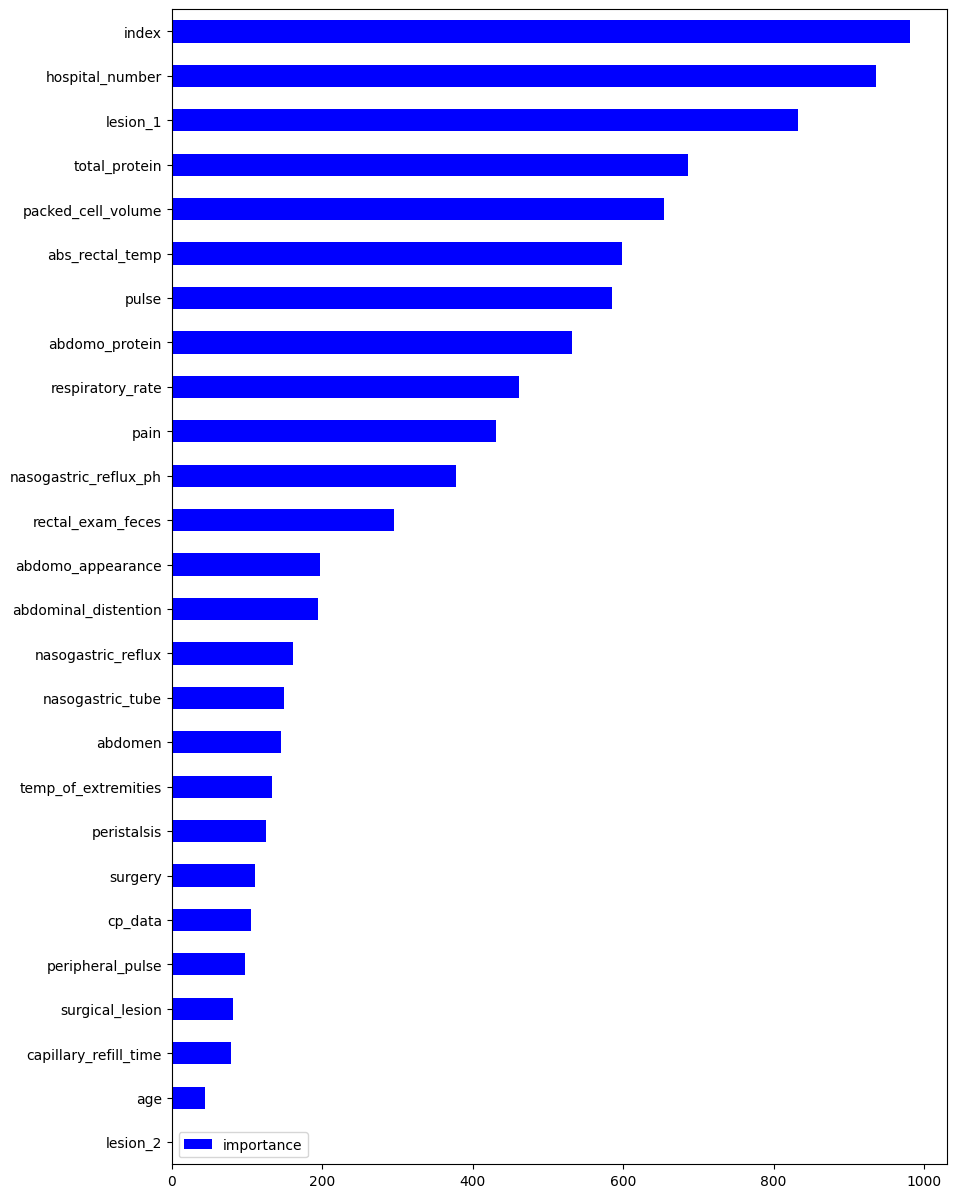

In [21]:
feature_importance.plot(kind='barh', figsize=(10, 15), color='b')

In [22]:
df.to_csv(OUTPUT_DIR + 'data.csv', index=False)

In [23]:
def file_to_xy(filename):
    data = pd.read_csv(filename, index_col=0)
    print(f'読み込み完了 {filename}')
    train = data[:1235].reset_index(drop=True)
    test = data[1235:].reset_index(drop=True).drop('outcome', axis=1) # 目的変数を指定する
    # 目的変数と説明変数に分割
    X = train.drop('outcome', axis=1) # 目的変数を指定する
    y = train['outcome'].values # 目的変数を指定する

    return data,test,train,X,y

In [24]:
filename = 'data.csv'
data,test,train,X,y = file_to_xy(OUTPUT_DIR + filename)

読み込み完了 data.csv


In [25]:
import pandas as pd
from xgboost import XGBClassifier # モデル作成

def file_to_xy(filename):
    data = pd.read_csv(filename, index_col=0)
    print(f'読み込み完了 {filename}')
    train = data[:1235].reset_index(drop=True)
    test = data[1235:].reset_index(drop=True).drop('outcome', axis=1) # 目的変数を指定する
    # 目的変数と説明変数に分割
    X = train.drop('outcome', axis=1) # 目的変数を指定する
    y = train['outcome'].values # 目的変数を指定する

    return data,test,train,X,y

filename = 'data.csv'
data,test,train,X,y = file_to_xy(OUTPUT_DIR + filename)

# モデル作成
model = XGBClassifier(n_estimators=20, random_state=42)
model.fit(X, y)

pred = model.predict_proba(test)
pred = pd.DataFrame(pred)

df_map = pd.DataFrame([[0, 'died'],
    [1, 'euthanized'],
    [2, 'lived']],
    columns=['num', 'str'])
# pred.head()

# 提出
submission_df = pd.DataFrame()
submission_df = pred
submission_df['id'] = test_id
submission_df = submission_df['id'].apply(lambda x: int(x))
submission_df = pd.concat([pred], axis=1)
# submission_df.head()

submission_df.to_csv(OUTPUT_DIR + 'submission.csv', index=False)

読み込み完了 data.csv
